# Script to Update Hydraulic Grade Values and Interpolate Sample Points Using Ordinary Kriging

### Introduction

The Python component of this project was used to automate daily data imports and maintenance required to dependably produce leakage area results. Since the project is applied to a real-world water distribution system, data was generated daily, creating the need to automate labor intensive tasks. To do this, the pandas and geopandas python libraries were used to handle most of the data management by performing data imports, data cleanup, data table merges, and hydraulic grade calculations. This was accomplished by importing regularly generated pressure information into pandas data frames and hydrant locational information into a geopandas spatially enabled geodataframes. 

The static pressure update processing is an ongoing program at the water department, so an automated script was developed to capture additional hydrant pressure tests daily. This placed information indicating large areas exhibiting water leakage in front of decision-makers in a timely manner so that large water breaks can be identified and repaired. The script was written in Python and developed using Jupyter Notebooks in conjunction with ArcGIS to document each step and support replication in other water systems. 


In [46]:
#Import the following python libraries
import sys, os, csv, fiona, datetime, arcpy
import pandas as pd
import numpy as np
import geopandas as gp
from geopandas import GeoSeries, GeoDataFrame
from shapely.geometry import Point
import matplotlib.pyplot as plt
from arcpy import env
from arcpy.sa import *

In [47]:
#Set the environment workspace and overwrite settings
arcpy.env.overwriteOutput = True
arcpy.env.workspace = "C:\\StaticPressureProcess\\StaticPressureData.gdb"

In [48]:
#Create variables for the pressure update csv, pressure test point file, and pressure zone polygon file
pressureUpdateFile = "C:\\StaticPressureProcess\\TasksExport.csv"
pressurePoint = "C:\\StaticPressureProcess\\StaticPressureData.gdb\\PZ1838A_PressureTestPnts"
pressureZone = "C:\\StaticPressureProcess\\StaticPressureData.gdb\\PZ1838A_Redefined"
outRaster = "C:\\StaticPressureProcess\\StaticPressureData.gdb\\LeakSurface_" + datetime.date.today().strftime("%m%d%Y")
clippedRaster = "C:\\StaticPressureProcess\\StaticPressureData.gdb\\ClippedSurface_" + datetime.date.today().strftime("%m%d%Y")
redefined1838aDma = "C:\\StaticPressureProcess\\DMA1838A.shp"
geoStatModel = "C:\\StaticPressureProcess\\OrdinaryKrigingModel_1838A_TheBest.xml"
geoStatLayer = "KrigingOutLayer"

In [49]:
#Use the fiona library to list all layers within the StaticPressureData geodatabase. 
#The list will be used to reference the layer imported with geopandas
fiona.listlayers("C:\\StaticPressureProcess\\StaticPressureData.gdb")

['wPressureTestPoints',
 'Export_Output',
 'PZ1838A_Redefined',
 'PZ1838A_PressureTestPnts',
 'Hydrants_1838A']

In [50]:
#Import the PZ1838_PressureTestPnts feature class as a geodataframe.
#The layer parameter is taken from the fiona generated list position of the desired geodatabase feature class.
testSites = gp.read_file("C:\\StaticPressureProcess\\StaticPressureData.gdb",driver='FileGDB', layer=3)
testSites

,FACILITYID,DateCollected,Elevation,AssetType,PressureZone,CartegraphTaskID,Comments,HydrantFireTagID,HydroGrade,Z,StaticPressure,geometry
0,WH-464,2015-10-13T00:00:00,1603.736174,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1067,1846.286174,1603.736174,105.0,POINT (3048707.218669921 752528.3329022601)
1,WH-1368,2015-10-13T00:00:00,1603.981406,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1220,1846.531406,1603.981406,105.0,POINT (3048737.828188755 752978.1771469265)
2,WH-3266,2015-10-13T00:00:00,1612.553537,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1274,1855.103537,1612.553537,105.0,POINT (3048314.026214838 753365.6924480125)
3,WH-470,2016-06-10T00:00:00,1611.592305,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1197,1807.942305,1611.592305,85.0,POINT (3048122.684405919 753544.1714217588)
4,WH-472,2016-06-30T00:00:00,1621.961008,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1093,1829.861008,1621.961008,90.0,POINT (3047753.687768586 753977.8569060937)
5,WH-1902,2016-06-30T00:00:00,1634.871588,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1229,1831.221588,1634.871588,85.0,POINT (3047225.766580336 753677.5189240947)
6,WH-1899,2016-06-30T00:00:00,1604.816847,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1263,1831.196847,1604.816847,98.0,POINT (3046504.406802587 753663.3437555954)
7,WH-1900,2016-06-30T00:00:00,1626.949892,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1230,1823.299892,1626.949892,85.0,POINT (3046916.103157669 753804.7647325918)
8,WH-1901,2016-06-30T00:00:00,1631.906957,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1232,1858.286957,1631.906957,98.0,POINT (3047137.796283837 754052.6330032572)
9,WH-3261,2016-06-30T00:00:00,1606.184790,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1228,1832.564790,1606.184790,98.0,POINT (3046562.371253587 754198.4352050945)


In [51]:
#Standardize the DateCollected column
testSites['DateCollected']=pd.to_datetime(testSites['DateCollected'])
testSites

,FACILITYID,DateCollected,Elevation,AssetType,PressureZone,CartegraphTaskID,Comments,HydrantFireTagID,HydroGrade,Z,StaticPressure,geometry
0,WH-464,2015-10-13,1603.736174,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1067,1846.286174,1603.736174,105.0,POINT (3048707.218669921 752528.3329022601)
1,WH-1368,2015-10-13,1603.981406,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1220,1846.531406,1603.981406,105.0,POINT (3048737.828188755 752978.1771469265)
2,WH-3266,2015-10-13,1612.553537,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1274,1855.103537,1612.553537,105.0,POINT (3048314.026214838 753365.6924480125)
3,WH-470,2016-06-10,1611.592305,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1197,1807.942305,1611.592305,85.0,POINT (3048122.684405919 753544.1714217588)
4,WH-472,2016-06-30,1621.961008,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1093,1829.861008,1621.961008,90.0,POINT (3047753.687768586 753977.8569060937)
5,WH-1902,2016-06-30,1634.871588,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1229,1831.221588,1634.871588,85.0,POINT (3047225.766580336 753677.5189240947)
6,WH-1899,2016-06-30,1604.816847,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1263,1831.196847,1604.816847,98.0,POINT (3046504.406802587 753663.3437555954)
7,WH-1900,2016-06-30,1626.949892,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1230,1823.299892,1626.949892,85.0,POINT (3046916.103157669 753804.7647325918)
8,WH-1901,2016-06-30,1631.906957,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1232,1858.286957,1631.906957,98.0,POINT (3047137.796283837 754052.6330032572)
9,WH-3261,2016-06-30,1606.184790,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1228,1832.564790,1606.184790,98.0,POINT (3046562.371253587 754198.4352050945)


In [52]:
#Import the pressure updates csv into a pandas data frame
staticUpdates = gp.read_file( "C:\\StaticPressureProcess\\TasksExport.csv")
staticUpdates

,Task ID,Asset,Activity,Static Pressure,Actual Stop Date,geometry
0,585457,Water Hydrant WH-204,Water Fire Flow,140,7/25/2019 12:00:00 AM,None
1,587460,Water Hydrant WH-3985,Water Quality Flush,100,7/25/2019 12:00:00 AM,None
2,583796,Water Hydrant WH-4141,Water Quality Flush,70,7/25/2019 12:00:00 AM,None
3,563622,Water Hydrant WH-1870,Water Quality Flush,100,7/24/2019 12:00:00 AM,None
4,563655,Water Hydrant WH-1214,Water Quality Flush,125,7/23/2019 12:00:00 AM,None
5,562656,Water Hydrant WH-2666,Water Quality Flush,70,7/15/2019 12:00:00 AM,None
6,584648,Water Hydrant WH-370,Water Fire Flow,100,7/12/2019 12:00:00 AM,None
7,586588,Water Hydrant WH-3485,Water Fire Flow,80,7/12/2019 12:00:00 AM,None
8,586587,Water Hydrant WH-384,Water Fire Flow,75,7/12/2019 12:00:00 AM,None
9,586584,Water Hydrant WH-373,Water Fire Flow,75,7/12/2019 12:00:00 AM,None


In [53]:
#Add the FACILITYID column and slice the text to only contain hydrant identifiers
staticUpdates['FACILITYID'] = staticUpdates.Asset.str[14:]

#Replace spaces with underscores
staticUpdates.columns = staticUpdates.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

#Convert the Static_Pressure column to numericvalues
staticUpdates['Static_Pressure']=pd.to_numeric(staticUpdates.Static_Pressure)
staticUpdates

,Task_ID,Asset,Activity,Static_Pressure,Actual_Stop_Date,geometry,FACILITYID
0,585457,Water Hydrant WH-204,Water Fire Flow,140,7/25/2019 12:00:00 AM,None,WH-204
1,587460,Water Hydrant WH-3985,Water Quality Flush,100,7/25/2019 12:00:00 AM,None,WH-3985
2,583796,Water Hydrant WH-4141,Water Quality Flush,70,7/25/2019 12:00:00 AM,None,WH-4141
3,563622,Water Hydrant WH-1870,Water Quality Flush,100,7/24/2019 12:00:00 AM,None,WH-1870
4,563655,Water Hydrant WH-1214,Water Quality Flush,125,7/23/2019 12:00:00 AM,None,WH-1214
5,562656,Water Hydrant WH-2666,Water Quality Flush,70,7/15/2019 12:00:00 AM,None,WH-2666
6,584648,Water Hydrant WH-370,Water Fire Flow,100,7/12/2019 12:00:00 AM,None,WH-370
7,586588,Water Hydrant WH-3485,Water Fire Flow,80,7/12/2019 12:00:00 AM,None,WH-3485
8,586587,Water Hydrant WH-384,Water Fire Flow,75,7/12/2019 12:00:00 AM,None,WH-384
9,586584,Water Hydrant WH-373,Water Fire Flow,75,7/12/2019 12:00:00 AM,None,WH-373


In [54]:
#Standardize the Actual_Stop_Date column
staticUpdates['Actual_Stop_Date']=pd.to_datetime(staticUpdates['Actual_Stop_Date'])
staticUpdates

,Task_ID,Asset,Activity,Static_Pressure,Actual_Stop_Date,geometry,FACILITYID
0,585457,Water Hydrant WH-204,Water Fire Flow,140,2019-07-25,None,WH-204
1,587460,Water Hydrant WH-3985,Water Quality Flush,100,2019-07-25,None,WH-3985
2,583796,Water Hydrant WH-4141,Water Quality Flush,70,2019-07-25,None,WH-4141
3,563622,Water Hydrant WH-1870,Water Quality Flush,100,2019-07-24,None,WH-1870
4,563655,Water Hydrant WH-1214,Water Quality Flush,125,2019-07-23,None,WH-1214
5,562656,Water Hydrant WH-2666,Water Quality Flush,70,2019-07-15,None,WH-2666
6,584648,Water Hydrant WH-370,Water Fire Flow,100,2019-07-12,None,WH-370
7,586588,Water Hydrant WH-3485,Water Fire Flow,80,2019-07-12,None,WH-3485
8,586587,Water Hydrant WH-384,Water Fire Flow,75,2019-07-12,None,WH-384
9,586584,Water Hydrant WH-373,Water Fire Flow,75,2019-07-12,None,WH-373


In [55]:
#Find and remove all rows with a Static_Pressure value equal to zero
zeroStaticP = staticUpdates[ staticUpdates['Static_Pressure'] == 0 ].index
staticUpdates.drop(zeroStaticP , inplace=True)

#Find and remove all rows with a Static_Pressure value greater than 200
zeroStaticP = staticUpdates[ staticUpdates['Static_Pressure'] > 300 ].index
staticUpdates.drop(zeroStaticP , inplace=True)

staticUpdates

,Task_ID,Asset,Activity,Static_Pressure,Actual_Stop_Date,geometry,FACILITYID
0,585457,Water Hydrant WH-204,Water Fire Flow,140,2019-07-25,None,WH-204
1,587460,Water Hydrant WH-3985,Water Quality Flush,100,2019-07-25,None,WH-3985
2,583796,Water Hydrant WH-4141,Water Quality Flush,70,2019-07-25,None,WH-4141
3,563622,Water Hydrant WH-1870,Water Quality Flush,100,2019-07-24,None,WH-1870
4,563655,Water Hydrant WH-1214,Water Quality Flush,125,2019-07-23,None,WH-1214
5,562656,Water Hydrant WH-2666,Water Quality Flush,70,2019-07-15,None,WH-2666
6,584648,Water Hydrant WH-370,Water Fire Flow,100,2019-07-12,None,WH-370
7,586588,Water Hydrant WH-3485,Water Fire Flow,80,2019-07-12,None,WH-3485
8,586587,Water Hydrant WH-384,Water Fire Flow,75,2019-07-12,None,WH-384
9,586584,Water Hydrant WH-373,Water Fire Flow,75,2019-07-12,None,WH-373


In [56]:
#Join the staticUpdates data frame to the testSites data frame using the FACILITYID field
#This creates a new data frame that contains the static pressure updates to apply to the 1838A test hydrants
mergedPressureInfo = testSites.merge(staticUpdates, on='FACILITYID')
mergedPressureInfo

,FACILITYID,DateCollected,Elevation,AssetType,PressureZone,CartegraphTaskID,Comments,HydrantFireTagID,HydroGrade,Z,StaticPressure,geometry_x,Task_ID,Asset,Activity,Static_Pressure,Actual_Stop_Date,geometry_y
0,WH-588,2017-08-15,1638.682377,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1127,1788.832377,1638.682377,65.0,POINT (3042682.476782423 744322.9451135918),519118,Water Hydrant WH-588,Water Fire Flow,85,2018-10-02,None
1,WH-2502,2015-08-11,1709.980765,Hydrant,1838 A,,FireHouse Hydrant Flow Data,3011,1848.580765,1709.980765,60.0,POINT (3046233.996254172 740883.6111130118),562658,Water Hydrant WH-2502,Water Quality Flush,60,2019-05-17,None
2,WH-1949,2015-08-11,1624.500275,Hydrant,1838 A,,FireHouse Hydrant Flow Data,3144,1820.850275,1624.500275,85.0,POINT (3043439.28235542 742222.7583690956),554757,Water Hydrant WH-1949,Water Fire Flow,90,2019-04-19,None
3,WH-1959,2015-12-30,1640.427372,Hydrant,1838 A,,FireHouse Hydrant Flow Data,3066,1825.227372,1640.427372,80.0,POINT (3049367.596942339 745307.9838259295),540303,Water Hydrant WH-1959,Water Fire Flow,90,2019-02-06,None
4,WH-2500,2017-08-11,1757.070925,Hydrant,1838 A,,FireHouse Hydrant Flow Data,2344,1826.370925,1757.070925,30.0,POINT (3046068.245929506 740008.3126667589),562626,Water Hydrant WH-2500,Water Quality Flush,40,2019-05-20,None
5,WH-1479,2017-08-11,1699.632011,Hydrant,1838 A,,FireHouse Hydrant Flow Data,2086,1803.582011,1699.632011,45.0,POINT (3046693.066530254 739095.6865392625),562638,Water Hydrant WH-1479,Water Quality Flush,50,2019-05-16,None
6,WH-1479,2017-08-11,1699.632011,Hydrant,1838 A,,FireHouse Hydrant Flow Data,2086,1803.582011,1699.632011,45.0,POINT (3046693.066530254 739095.6865392625),493331,Water Hydrant WH-1479,Water Fire Flow,44,2018-05-08,None
7,WH-650,2015-07-17,1645.266168,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1021,1818.516168,1645.266168,75.0,POINT (3043049.633528423 747282.5874882564),562633,Water Hydrant WH-650,Water Quality Flush,95,2019-06-05,None
8,WH-700,2016-01-19,1676.306361,Hydrant,1838 A,,FireHouse Hydrant Flow Data,4106,1814.906361,1676.306361,60.0,POINT (3039291.136780336 743252.5506008416),526149,Water Hydrant WH-700,Water Fire Flow,70,2018-11-05,None
9,WH-705,2016-01-19,1682.559096,Hydrant,1838 A,,FireHouse Hydrant Flow Data,4045,1821.159096,1682.559096,60.0,POINT (3039489.524178836 743508.1042235941),520589,Water Hydrant WH-705,Water Fire Flow,75,2018-10-30,None


In [57]:
#Update new StaticPressure column
mergedPressureInfo.StaticPressure = mergedPressureInfo.Static_Pressure

#Recalculate the Hydrograde column
mergedPressureInfo.HydroGrade = mergedPressureInfo.Elevation + 2.31 * mergedPressureInfo.StaticPressure

#Update the DateCollected column with new dates from the Actual_Stop_Date column
mergedPressureInfo.DateCollected = mergedPressureInfo.Actual_Stop_Date
mergedPressureInfo

,FACILITYID,DateCollected,Elevation,AssetType,PressureZone,CartegraphTaskID,Comments,HydrantFireTagID,HydroGrade,Z,StaticPressure,geometry_x,Task_ID,Asset,Activity,Static_Pressure,Actual_Stop_Date,geometry_y
0,WH-588,2018-10-02,1638.682377,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1127,1835.032377,1638.682377,85,POINT (3042682.476782423 744322.9451135918),519118,Water Hydrant WH-588,Water Fire Flow,85,2018-10-02,None
1,WH-2502,2019-05-17,1709.980765,Hydrant,1838 A,,FireHouse Hydrant Flow Data,3011,1848.580765,1709.980765,60,POINT (3046233.996254172 740883.6111130118),562658,Water Hydrant WH-2502,Water Quality Flush,60,2019-05-17,None
2,WH-1949,2019-04-19,1624.500275,Hydrant,1838 A,,FireHouse Hydrant Flow Data,3144,1832.400275,1624.500275,90,POINT (3043439.28235542 742222.7583690956),554757,Water Hydrant WH-1949,Water Fire Flow,90,2019-04-19,None
3,WH-1959,2019-02-06,1640.427372,Hydrant,1838 A,,FireHouse Hydrant Flow Data,3066,1848.327372,1640.427372,90,POINT (3049367.596942339 745307.9838259295),540303,Water Hydrant WH-1959,Water Fire Flow,90,2019-02-06,None
4,WH-2500,2019-05-20,1757.070925,Hydrant,1838 A,,FireHouse Hydrant Flow Data,2344,1849.470925,1757.070925,40,POINT (3046068.245929506 740008.3126667589),562626,Water Hydrant WH-2500,Water Quality Flush,40,2019-05-20,None
5,WH-1479,2019-05-16,1699.632011,Hydrant,1838 A,,FireHouse Hydrant Flow Data,2086,1815.132011,1699.632011,50,POINT (3046693.066530254 739095.6865392625),562638,Water Hydrant WH-1479,Water Quality Flush,50,2019-05-16,None
6,WH-1479,2018-05-08,1699.632011,Hydrant,1838 A,,FireHouse Hydrant Flow Data,2086,1801.272011,1699.632011,44,POINT (3046693.066530254 739095.6865392625),493331,Water Hydrant WH-1479,Water Fire Flow,44,2018-05-08,None
7,WH-650,2019-06-05,1645.266168,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1021,1864.716168,1645.266168,95,POINT (3043049.633528423 747282.5874882564),562633,Water Hydrant WH-650,Water Quality Flush,95,2019-06-05,None
8,WH-700,2018-11-05,1676.306361,Hydrant,1838 A,,FireHouse Hydrant Flow Data,4106,1838.006361,1676.306361,70,POINT (3039291.136780336 743252.5506008416),526149,Water Hydrant WH-700,Water Fire Flow,70,2018-11-05,None
9,WH-705,2018-10-30,1682.559096,Hydrant,1838 A,,FireHouse Hydrant Flow Data,4045,1855.809096,1682.559096,75,POINT (3039489.524178836 743508.1042235941),520589,Water Hydrant WH-705,Water Fire Flow,75,2018-10-30,None


In [58]:
#Remove unneeded fields from the data frame
del mergedPressureInfo['Task_ID']
del mergedPressureInfo['Asset']
del mergedPressureInfo['Activity']
del mergedPressureInfo['Static_Pressure']
del mergedPressureInfo['Actual_Stop_Date']
del mergedPressureInfo['geometry_y']

#Rename the geometry column
mergedPressureInfo.rename(columns={"geometry_x":"geometry"}, inplace=True)
mergedPressureInfo

,FACILITYID,DateCollected,Elevation,AssetType,PressureZone,CartegraphTaskID,Comments,HydrantFireTagID,HydroGrade,Z,StaticPressure,geometry
0,WH-588,2018-10-02,1638.682377,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1127,1835.032377,1638.682377,85,POINT (3042682.476782423 744322.9451135918)
1,WH-2502,2019-05-17,1709.980765,Hydrant,1838 A,,FireHouse Hydrant Flow Data,3011,1848.580765,1709.980765,60,POINT (3046233.996254172 740883.6111130118)
2,WH-1949,2019-04-19,1624.500275,Hydrant,1838 A,,FireHouse Hydrant Flow Data,3144,1832.400275,1624.500275,90,POINT (3043439.28235542 742222.7583690956)
3,WH-1959,2019-02-06,1640.427372,Hydrant,1838 A,,FireHouse Hydrant Flow Data,3066,1848.327372,1640.427372,90,POINT (3049367.596942339 745307.9838259295)
4,WH-2500,2019-05-20,1757.070925,Hydrant,1838 A,,FireHouse Hydrant Flow Data,2344,1849.470925,1757.070925,40,POINT (3046068.245929506 740008.3126667589)
5,WH-1479,2019-05-16,1699.632011,Hydrant,1838 A,,FireHouse Hydrant Flow Data,2086,1815.132011,1699.632011,50,POINT (3046693.066530254 739095.6865392625)
6,WH-1479,2018-05-08,1699.632011,Hydrant,1838 A,,FireHouse Hydrant Flow Data,2086,1801.272011,1699.632011,44,POINT (3046693.066530254 739095.6865392625)
7,WH-650,2019-06-05,1645.266168,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1021,1864.716168,1645.266168,95,POINT (3043049.633528423 747282.5874882564)
8,WH-700,2018-11-05,1676.306361,Hydrant,1838 A,,FireHouse Hydrant Flow Data,4106,1838.006361,1676.306361,70,POINT (3039291.136780336 743252.5506008416)
9,WH-705,2018-10-30,1682.559096,Hydrant,1838 A,,FireHouse Hydrant Flow Data,4045,1855.809096,1682.559096,75,POINT (3039489.524178836 743508.1042235941)


In [59]:
#Remove duplicate values
mergedPressureInfo = mergedPressureInfo.sort_values('DateCollected',ascending=True)
mergedPressureInfo = mergedPressureInfo.drop_duplicates(subset='FACILITYID', keep='first')
mergedPressureInfo = mergedPressureInfo.sort_values('FACILITYID',ascending=True)
mergedPressureInfo

,FACILITYID,DateCollected,Elevation,AssetType,PressureZone,CartegraphTaskID,Comments,HydrantFireTagID,HydroGrade,Z,StaticPressure,geometry
25,WH-1003,2019-04-19,1643.050636,Hydrant,1838 A,,FireHouse Hydrant Flow Data,2365,1827.850636,1643.050636,80,POINT (3039780.971758671 738649.4745051786)
74,WH-106,2019-06-28,1489.214893,Hydrant,1838 A,,FireHouse Hydrant Flow Data,6070,1835.714893,1489.214893,150,POINT (3037027.660664253 769269.5622150078)
81,WH-1078,2019-05-16,1672.935303,Hydrant,1838 A,,None,3182,1846.185303,1672.935303,75,POINT (3048427.985632587 739982.9098304287)
76,WH-1353,2019-06-03,1578.058962,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1217,1728.208962,1578.058962,65,POINT (3043682.933114838 753790.7316241786)
13,WH-1360,2019-06-20,1651.534164,Hydrant,1838 A,,FireHouse Hydrant Flow Data,5227,1808.614164,1651.534164,68,POINT (3033042.951114003 749963.4689375088)
56,WH-146,2019-06-11,1552.018163,Hydrant,1838 A,,FireHouse Hydrant Flow Data,6191,1829.218163,1552.018163,120,POINT (3029506.30136317 763655.594440341)
6,WH-1479,2018-05-08,1699.632011,Hydrant,1838 A,,FireHouse Hydrant Flow Data,2086,1801.272011,1699.632011,44,POINT (3046693.066530254 739095.6865392625)
49,WH-152,2019-06-12,1554.143996,Hydrant,1838 A,,FireHouse Hydrant Flow Data,6363,1669.643996,1554.143996,50,POINT (3025295.224155422 761586.8151133433)
97,WH-1521,2019-06-11,1537.180054,Hydrant,1838 A,,None,6746,1825.930054,1537.180054,125,POINT (3029028.504418503 762991.5094824284)
39,WH-1525,2019-07-03,1520.769313,Hydrant,1838 A,,FireHouse Hydrant Flow Data,6293,1807.209313,1520.769313,124,POINT (3036292.925913256 764215.5257351771)


## Update testSite values with the new static pressure test values and export to a shapefile

In [60]:
#Set the testSites index to the FACILITYID column
testSites = testSites.set_index('FACILITYID')

In [61]:
testSites

,DateCollected,Elevation,AssetType,PressureZone,CartegraphTaskID,Comments,HydrantFireTagID,HydroGrade,Z,StaticPressure,geometry
FACILITYID,,,,,,,,,,,
WH-464,2015-10-13,1603.736174,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1067,1846.286174,1603.736174,105.0,POINT (3048707.218669921 752528.3329022601)
WH-1368,2015-10-13,1603.981406,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1220,1846.531406,1603.981406,105.0,POINT (3048737.828188755 752978.1771469265)
WH-3266,2015-10-13,1612.553537,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1274,1855.103537,1612.553537,105.0,POINT (3048314.026214838 753365.6924480125)
WH-470,2016-06-10,1611.592305,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1197,1807.942305,1611.592305,85.0,POINT (3048122.684405919 753544.1714217588)
WH-472,2016-06-30,1621.961008,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1093,1829.861008,1621.961008,90.0,POINT (3047753.687768586 753977.8569060937)
WH-1902,2016-06-30,1634.871588,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1229,1831.221588,1634.871588,85.0,POINT (3047225.766580336 753677.5189240947)
WH-1899,2016-06-30,1604.816847,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1263,1831.196847,1604.816847,98.0,POINT (3046504.406802587 753663.3437555954)
WH-1900,2016-06-30,1626.949892,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1230,1823.299892,1626.949892,85.0,POINT (3046916.103157669 753804.7647325918)
WH-1901,2016-06-30,1631.906957,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1232,1858.286957,1631.906957,98.0,POINT (3047137.796283837 754052.6330032572)


In [62]:
#Set the mergedPressureInfo data frame index to the FACILITYID column
mergedPressureInfo = mergedPressureInfo.set_index('FACILITYID')

In [63]:
mergedPressureInfo

,DateCollected,Elevation,AssetType,PressureZone,CartegraphTaskID,Comments,HydrantFireTagID,HydroGrade,Z,StaticPressure,geometry
FACILITYID,,,,,,,,,,,
WH-1003,2019-04-19,1643.050636,Hydrant,1838 A,,FireHouse Hydrant Flow Data,2365,1827.850636,1643.050636,80,POINT (3039780.971758671 738649.4745051786)
WH-106,2019-06-28,1489.214893,Hydrant,1838 A,,FireHouse Hydrant Flow Data,6070,1835.714893,1489.214893,150,POINT (3037027.660664253 769269.5622150078)
WH-1078,2019-05-16,1672.935303,Hydrant,1838 A,,None,3182,1846.185303,1672.935303,75,POINT (3048427.985632587 739982.9098304287)
WH-1353,2019-06-03,1578.058962,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1217,1728.208962,1578.058962,65,POINT (3043682.933114838 753790.7316241786)
WH-1360,2019-06-20,1651.534164,Hydrant,1838 A,,FireHouse Hydrant Flow Data,5227,1808.614164,1651.534164,68,POINT (3033042.951114003 749963.4689375088)
WH-146,2019-06-11,1552.018163,Hydrant,1838 A,,FireHouse Hydrant Flow Data,6191,1829.218163,1552.018163,120,POINT (3029506.30136317 763655.594440341)
WH-1479,2018-05-08,1699.632011,Hydrant,1838 A,,FireHouse Hydrant Flow Data,2086,1801.272011,1699.632011,44,POINT (3046693.066530254 739095.6865392625)
WH-152,2019-06-12,1554.143996,Hydrant,1838 A,,FireHouse Hydrant Flow Data,6363,1669.643996,1554.143996,50,POINT (3025295.224155422 761586.8151133433)
WH-1521,2019-06-11,1537.180054,Hydrant,1838 A,,None,6746,1825.930054,1537.180054,125,POINT (3029028.504418503 762991.5094824284)


In [64]:
#Run the update function on the testSites data frame
testSites.update(mergedPressureInfo)

In [65]:
#Reset the indexes
testSites.reset_index(inplace=True)

In [66]:
testSites

,FACILITYID,DateCollected,Elevation,AssetType,PressureZone,CartegraphTaskID,Comments,HydrantFireTagID,HydroGrade,Z,StaticPressure,geometry
0,WH-464,2015-10-13,1603.736174,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1067,1846.286174,1603.736174,105.0,POINT (3048707.218669921 752528.3329022601)
1,WH-1368,2015-10-13,1603.981406,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1220,1846.531406,1603.981406,105.0,POINT (3048737.828188755 752978.1771469265)
2,WH-3266,2015-10-13,1612.553537,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1274,1855.103537,1612.553537,105.0,POINT (3048314.026214838 753365.6924480125)
3,WH-470,2016-06-10,1611.592305,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1197,1807.942305,1611.592305,85.0,POINT (3048122.684405919 753544.1714217588)
4,WH-472,2016-06-30,1621.961008,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1093,1829.861008,1621.961008,90.0,POINT (3047753.687768586 753977.8569060937)
5,WH-1902,2016-06-30,1634.871588,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1229,1831.221588,1634.871588,85.0,POINT (3047225.766580336 753677.5189240947)
6,WH-1899,2016-06-30,1604.816847,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1263,1831.196847,1604.816847,98.0,POINT (3046504.406802587 753663.3437555954)
7,WH-1900,2016-06-30,1626.949892,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1230,1823.299892,1626.949892,85.0,POINT (3046916.103157669 753804.7647325918)
8,WH-1901,2016-06-30,1631.906957,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1232,1858.286957,1631.906957,98.0,POINT (3047137.796283837 754052.6330032572)
9,WH-3261,2016-06-30,1606.184790,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1228,1832.564790,1606.184790,98.0,POINT (3046562.371253587 754198.4352050945)


In [67]:
#Convert the merged data frame to a GeoDataFrame and remove null HydroGrade Values
updatedGdf = gp.GeoDataFrame(testSites, geometry='geometry')
NewGdf = updatedGdf[updatedGdf.HydroGrade.notnull()]
NewGdf

,FACILITYID,DateCollected,Elevation,AssetType,PressureZone,CartegraphTaskID,Comments,HydrantFireTagID,HydroGrade,Z,StaticPressure,geometry
0,WH-464,2015-10-13,1603.736174,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1067,1846.286174,1603.736174,105.0,POINT (3048707.218669921 752528.3329022601)
1,WH-1368,2015-10-13,1603.981406,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1220,1846.531406,1603.981406,105.0,POINT (3048737.828188755 752978.1771469265)
2,WH-3266,2015-10-13,1612.553537,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1274,1855.103537,1612.553537,105.0,POINT (3048314.026214838 753365.6924480125)
3,WH-470,2016-06-10,1611.592305,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1197,1807.942305,1611.592305,85.0,POINT (3048122.684405919 753544.1714217588)
4,WH-472,2016-06-30,1621.961008,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1093,1829.861008,1621.961008,90.0,POINT (3047753.687768586 753977.8569060937)
5,WH-1902,2016-06-30,1634.871588,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1229,1831.221588,1634.871588,85.0,POINT (3047225.766580336 753677.5189240947)
6,WH-1899,2016-06-30,1604.816847,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1263,1831.196847,1604.816847,98.0,POINT (3046504.406802587 753663.3437555954)
7,WH-1900,2016-06-30,1626.949892,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1230,1823.299892,1626.949892,85.0,POINT (3046916.103157669 753804.7647325918)
8,WH-1901,2016-06-30,1631.906957,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1232,1858.286957,1631.906957,98.0,POINT (3047137.796283837 754052.6330032572)
9,WH-3261,2016-06-30,1606.184790,Hydrant,1838 A,,FireHouse Hydrant Flow Data,1228,1832.564790,1606.184790,98.0,POINT (3046562.371253587 754198.4352050945)


In [68]:
#Convert the DateCollected column to string values in order to export to shapefile
NewGdf['DateCollected']=NewGdf['DateCollected'].astype(str)

C:\ProgramData\Anaconda3\envs\WaterPy\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


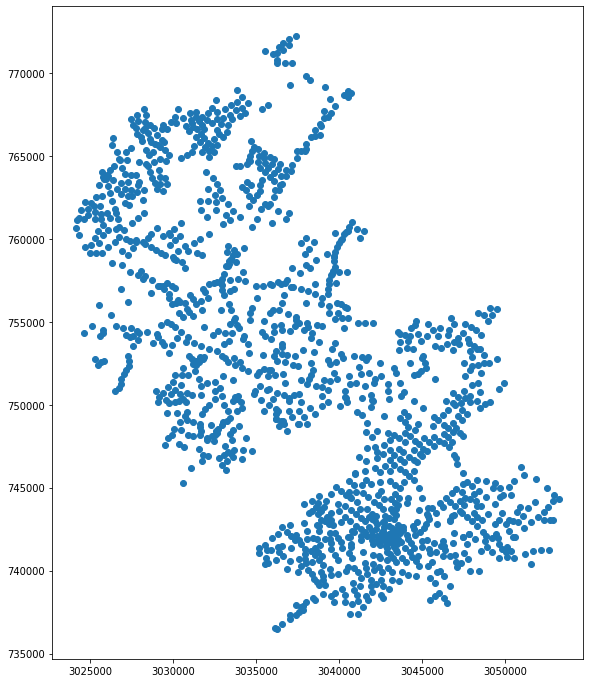

In [69]:
#Set the new geodataframe's projection and plot the new pressure tests within 1838A
NewGdf.crs = {"init":"epsg:2274"}
updatedGdf.plot(figsize=(12,12));

In [70]:
##Create new shapefile name and export the geodataframe to new shapefile
shpFileName = r"C:\StaticPressureProcess\UpdatedStaticPressureTests_" + datetime.date.today().strftime("%m%d%Y") + ".shp"

In [71]:
NewGdf.to_file(shpFileName)

## Run the ordinary kriging model on the updated hydrant pressure points

Run the Kriging interpolation using the pressure point layer. This step creates a Geostatistical Layer using tools from Geostatistical Analyst. The tool uses an existing Geostatistial layer as a model source to duplicate its parameters and should be stored in the project workspace.

In [72]:
#Check out the ESRI Spatial and Geostatistical Analyst Extensions
arcpy.CheckOutExtension("Spatial")
arcpy.CheckOutExtension("GeoStats")

'CheckedOut'

In [73]:
krigingInLayer = shpFileName + " X=Shape Y=Shape F1=HydroGrade"

In [74]:
#arcpy.GACreateGeostatisticalLayer_ga(in_ga_model_source, in_datasets, out_layer)
arcpy.GACreateGeostatisticalLayer_ga(geoStatModel, krigingInLayer, geoStatLayer)

<Result 'KrigingOutLayer'>

In [75]:
#Export Geostatistical layer to a raster
arcpy.GALayerToRasters_ga(geoStatLayer, outRaster)

<Result 'C:\\StaticPressureProcess\\StaticPressureData.gdb\\LeakSurface_10282019'>

In [79]:
#Clip the interpolation surface to the desired polygon boundary layer
arcpy.Clip_management(outRaster, "#",clippedRaster, redefined1838aDma,"0","ClippingGeometry")

<Result 'C:\\StaticPressureProcess\\StaticPressureData.gdb\\ClippedSurface_10282019'>

In [80]:
#Check back in the ESRI Spatial and Geostatistical Analyst Extensions
arcpy.CheckInExtension("Spatial")
arcpy.CheckInExtension("GeoStats")

'CheckedIn'

In [81]:
print("Completed Script")

Completed Script
